# Dogs vs Cats: A domestic cuteness battle

This notebook addresses one of the most common tasks on Deep Learning: Object Recognition. It comes from the data presented at [this Kaggle competition](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification) that presented the problem as a binary classification one, with either the object present in the photo being a cat or a dog.

We will be using Keras in order to create a Convolutional Neural Network from scratch, and TensorFlow public repository of trained models to boost up our accuracy using the architecture VGG16 trained on the famous `imagenet` dataset.

Without further ado, let's start coding!


In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16

Init Plugin
Init Graph Optimizer
Init Kernel


## Data Preparation Flow

We downloaded the zip file in our Downloads folder, then unzipped it and located its contents inside the `dogs-vs-cats` folder, in order to keep it outside the git repository due to its heavy weight (~860MB). As the images are presented as different files, we will need to create a generator using Keras' own utilities to pass through our directory.

In [2]:
data_directory = "/Users/josualonso/Downloads/dogs-vs-cats"
train_directory = os.path.join(data_directory, "train")
test_directory = os.path.join(data_directory, "test")

In order to deal with the labelling of our images, first we could create a Pandas' DataFrame to asssign labels to each of the files in our train directory:

In [3]:
filenames = os.listdir(train_directory)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    categories.append('dog') if category == 'dog' else categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

Now we need to divide our dataset into train and dev (or validation) sets, taking into account that we can also use Data Augmentation to expand our training examples. We can wrap this inside our train generator, as the validation set should remain unmodified.

In [5]:
train_df, validate_df = train_test_split(df, train_size=0.80)

train_data_gen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.8
)

validation_data_gen = ImageDataGenerator(
    rescale=1/255.,
)

In [6]:
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_directory,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=20,
)

validation_generator = validation_data_gen.flow_from_dataframe(
    dataframe=validate_df,
    directory=train_directory,
    x_col='filename',
    y_col='category',
    target_size=(150, 150),
    batch_size=20,
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Vanilla ConvNet

To create our own convolutional network we need to create two different blocks of layers:
1. The convolutional block, based on the succession of convolutional and pooling layers that apply self-taught transformations to our images in order to extract features that make easier to identify the class present on the image.
2. The dense block, which gathers the information obtained from the convolutional transformations and fit a classification model on top of it

It is also needed to consider that in between these two blocks a `Flatten` layer is needed to convert the 4 dimensional outputs of the convolutional block into a 1D vector that the dense block may interpret easily.

We will also apply L2 regularizations and dropout layers to avoid overfitting our network, due to the small set of images that we are presented with (20K).

In [7]:
model = Sequential([
    Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=(150, 150, 3)),
    MaxPool2D(2),
    Conv2D(96, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPool2D(2),
    Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPool2D(2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(254, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(2, activation='softmax'),
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

Metal device set to: Apple M1 Pro


2022-02-19 20:01:26.295184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-19 20:01:26.295335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 96)        27744     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       110720    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

In [9]:
checkpoint = ModelCheckpoint(filepath='../models/dog-cat-model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=1000,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=250,
    callbacks=[checkpoint, early_stopping],
)

2022-02-19 20:01:27.211448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-19 20:01:27.212473: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2022-02-19 20:01:27.436140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - ETA: 0s - loss: 0.7796 - accuracy: 0.5538

2022-02-19 20:02:43.427153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 84s 83ms/step - loss: 0.7796 - accuracy: 0.5538 - val_loss: 0.6777 - val_accuracy: 0.5944
Epoch 2/30
1000/1000 [==============================] - 82s 82ms/step - loss: 0.6562 - accuracy: 0.6348 - val_loss: 0.6138 - val_accuracy: 0.6802
Epoch 3/30
1000/1000 [==============================] - 81s 81ms/step - loss: 0.6274 - accuracy: 0.6701 - val_loss: 0.6046 - val_accuracy: 0.6974
Epoch 4/30
1000/1000 [==============================] - 82s 82ms/step - loss: 0.6063 - accuracy: 0.6951 - val_loss: 0.5847 - val_accuracy: 0.7140
Epoch 5/30
1000/1000 [==============================] - 82s 82ms/step - loss: 0.5967 - accuracy: 0.7090 - val_loss: 0.5736 - val_accuracy: 0.7194
Epoch 6/30
1000/1000 [==============================] - 82s 82ms/step - loss: 0.5836 - accuracy: 0.7228 - val_loss: 0.5501 - val_accuracy: 0.7384
Epoch 7/30
1000/1000 [==============================] - 81s 81ms/step - loss: 0.5697 - accuracy: 0.7320 - val_loss: 0.5451 - val_accura

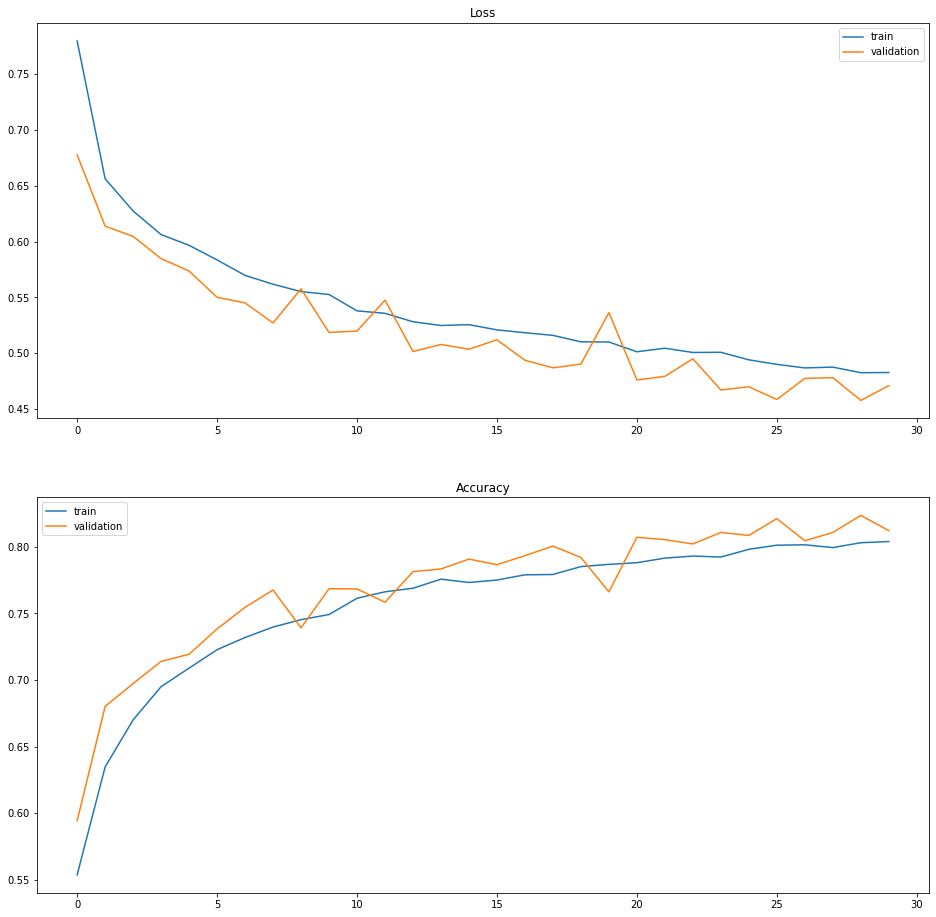

In [10]:
fig, ax = plt.subplots(figsize=(16, 16), nrows=2)

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='validation')
ax[1].legend()
ax[1].set_title('Accuracy')

plt.show()

By looking at the output of our plots, we see that our training went adequately and our network managed an accuracy of `80%` on the training set and `82%` on the validation set after 30 epochs.

We see that reaching an increase above 80% seems really difficult using our model even though we keep increasing the training epochs, and we could maybe increase a little that threshold by tweaking our model but we will still be far of the 100% accuracy.

So, in order to further increase the accuracy of our model we can try Transfer Learning.

## Transfer Learning

We first need to load the VGG16 architecture trained on the `imagenet` set, and also choosing not to include the top layers as we will be training a different classifier on top of that structure

In [11]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

To avoid training the part of the model provided by the VGG16 architecture, we are going to first pass all our examples through it and use those outputs as the inputs of the model we are going to create:

In [12]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(df, df_dir, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 2))
    generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=df_dir,
        x_col='filename',
        y_col='category',
        target_size=(150, 150),
        batch_size=20,
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_df, train_directory, 20000)
validation_features, validation_labels = extract_features(validate_df, train_directory, 5000)

Found 20000 validated image filenames belonging to 2 classes.


2022-02-19 20:41:42.709665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Found 5000 validated image filenames belonging to 2 classes.


In [13]:
train_features = np.reshape(train_features, (20000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (5000, 4 * 4 * 512))

This time, we are going to use a smaller Dense layer with only 1 hidden layer of 256 units, as hopefully this is one to suffice to demonstrate a better accuracy than our vanilla ConvNet:

In [23]:
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_dim=4 * 4 * 512),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(2, activation='softmax'),
])

model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
checkpoint = ModelCheckpoint(
    filepath='../models/dog-cat-model-transfer.h5',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels),
    callbacks=[checkpoint],
)

Epoch 1/30
   6/1000 [..............................] - ETA: 11s - loss: 4.0486 - accuracy: 0.4583 

2022-02-19 20:52:33.968361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.8473

2022-02-19 20:52:43.779297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 11s 11ms/step - loss: 0.4525 - accuracy: 0.8473 - val_loss: 0.2883 - val_accuracy: 0.9014
Epoch 2/30
1000/1000 [==============================] - 11s 11ms/step - loss: 0.3229 - accuracy: 0.8871 - val_loss: 0.3289 - val_accuracy: 0.8698
Epoch 3/30
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2935 - accuracy: 0.8979 - val_loss: 0.2657 - val_accuracy: 0.9080
Epoch 4/30
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2806 - accuracy: 0.9037 - val_loss: 0.2632 - val_accuracy: 0.9094
Epoch 5/30
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2708 - accuracy: 0.9057 - val_loss: 0.2768 - val_accuracy: 0.9020
Epoch 6/30
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2638 - accuracy: 0.9088 - val_loss: 0.3016 - val_accuracy: 0.8912
Epoch 7/30
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2606 - accuracy: 0.9113 - val_loss: 0.2673 - val_accura

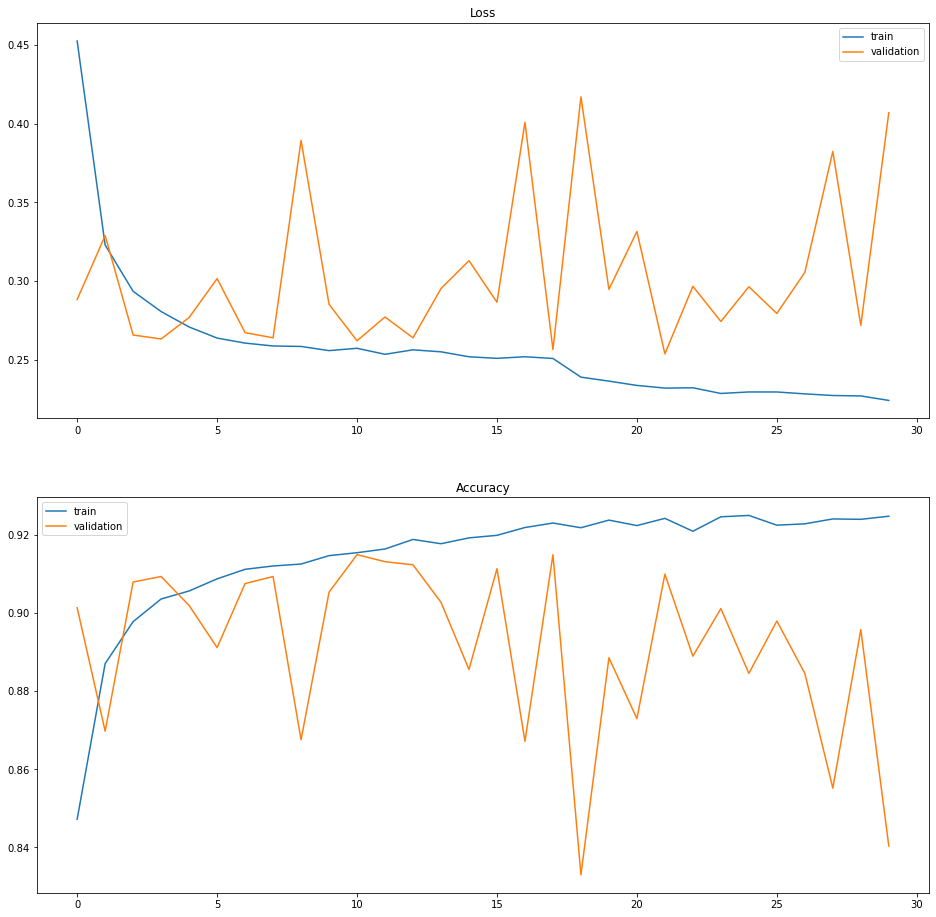

In [25]:
fig, ax = plt.subplots(figsize=(16, 16), nrows=2)

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='validation')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='validation')
ax[1].legend()
ax[1].set_title('Accuracy')

plt.show()

As we can easily observe, this time the performance of our model reached an accuracy of `89%` on train only after 1 epoch, being stable on the `90%` threshold after that. We also see that even though we used L2 and Dropout, our model overfits after 14 epochs and the validation loss is not as stable as the training one. This issue could be solved by adding an `EarlyStopping` callback as before, but as we are saving the best model it is not much of a problem apart from the extra computation, and it also shows us how training went.

## Fine Tuning

Apart from transforming our data using the VGG16 model downloaded, we can also modify its weights and make it even more suited to the task in hand. Doing so is called **Fine Tuning** and is often used in Deep Learning when computational power and a good enough quantity of data are available.

In this exercise we are only to unfreeze the weights of the last 3 layers of the VGG16 model, as we hope modifications on those layers only are going to be enough to boost our accuracy a little bit more.

## Error Analysis

After using Fine Tuning, we still got some errors for our model. One step to take now could be to manually check some of the mistakes made and see in which examples our model struggled the most:

## Predictions

Now that our model has been checked and push to an accuracy of over `XX%`, we may pass the test images and generate some predictions based on them:

By checking some of the images at random, we have a good sense of our model's performance on the test set. After all our hard work it seems like the model is performing well and our cute friends are well classified.

## Conclusions

We saw how Convolutional Networks...